For MS training we have 3 datasets: train, validation and holdout

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib

import matplotlib.pyplot as plt
import os
import h5py

# keras
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence
import keras.backend as K

from config import *
from utils import normalize_float

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "5"
set_session(tf.Session(config=config))

In [3]:
zero_one_normalize = True
dtype = np.float32

In [4]:
# load hdf5 files and extract columns
train_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/train_dataset_FLAIR_lesions_filled.h5', 'r')
holdout_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/holdout_dataset_FLAIR_lesions_filled.h5', 'r')

X_train, y_train = train_h5['X'], train_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

train_lesions_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/train_dataset_lesions.h5', 'r')
holdout_lesions_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/holdout_dataset_lesions.h5', 'r')

lesion_masks_train = train_lesions_h5['masks']
lesion_masks_holdout = holdout_lesions_h5['masks']

In [5]:
# convert data to numpy arrays
X_train = np.array(X_train, dtype=dtype)
y_train = np.array(y_train)

X_holdout = np.array(X_holdout, dtype=dtype)
y_holdout = np.array(y_holdout)

In [6]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(y_train[y_train==0.])))
print("Number of MS patients: {}".format(len(y_train[y_train==1.])))

Total datset length: 124
Number of healthy controls: 61
Number of MS patients: 63


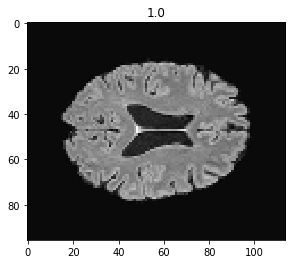

In [7]:
plt.imshow(X_train[0][:,:,49], cmap='gray')
plt.title(y_train[0])
plt.show()

## Normalize

In [8]:
zero_one_normalize = True
dtype = np.float32
model_path = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/model_trial_6.h5"
pretrained_weights = "/analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/weights-augm-trial0-improvement-BEST.hdf5"

In [9]:
# 0-1 scaling
if zero_one_normalize:
    X_train = normalize_float(X_train)
    X_holdout = normalize_float(X_holdout)

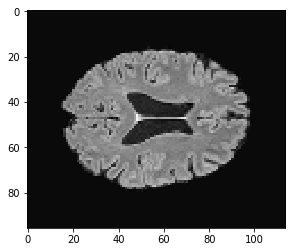

In [10]:
plt.imshow(X_train[0][:,:,49], cmap='gray')
plt.show()

## Use CNN as feature extractor

In [11]:
model = load_model(model_path)
model.load_weights(pretrained_weights)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv3D)              (None, 94, 112, 94, 64)   1792      
_________________________________________________________________
Pool_1 (MaxPooling3D)        (None, 31, 37, 31, 64)    0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 31, 37, 31, 64)    0         
_________________________________________________________________
Conv_2 (Conv3D)              (None, 29, 35, 29, 64)    110656    
_________________________________________________________________
Pool_2 (MaxPooling3D)        (None, 9, 11, 9, 64)      0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 9, 11, 9, 64)      0         
_________________________________________________________________
Conv_3 (Conv3D)              (None, 7, 9, 7, 64)       110656    
__________

In [12]:
output_layer = "flatten_7"
feature_extractor = Model(inputs=model.input,
                          outputs=model.get_layer(output_layer).output)

In [13]:
def encode_samples(X, encoder, out_dim=128, dtype=np.float32):
    encoded_X = np.empty(shape=(X.shape[0], out_dim), dtype=dtype)
    # add channel dimension
    X = np.expand_dims(X, axis=-1)
    # add possible additional dimensions (e.g. num_samples)
    while len(X.shape) < len(encoder.input.shape) + 1:
        X = np.expand_dims(X, axis=1)
    for i, x in enumerate(X):
        code = encoder.predict(x)
        encoded_X[i] = code
    return encoded_X

In [14]:
encoded_X_train, encoded_X_holdout = [encode_samples(X, feature_extractor) for X in [X_train, X_holdout]]

In [15]:
encoded_X_train.shape

(124, 128)

In [16]:
h5 = h5py.File('/analysis/share/Ritter/MS/CIS/encoded_x_train-ADNI_trial_6-MS_trial_0-layer_flatten_7.h5', 'w')
h5.create_dataset('X', data=encoded_X_train)
h5.create_dataset('y', data=y_train)
h5.close()

In [17]:
h5 = h5py.File('/analysis/share/Ritter/MS/CIS/encoded_x_holdout-ADNI_trial_6-MS_trial_0-layer_flatten_7.h5', 'w')
h5.create_dataset('X', data=encoded_X_holdout)
h5.create_dataset('y', data=y_holdout)
h5.close()

In [18]:
quit()